<a href="https://colab.research.google.com/github/eukeun/predict-future-sales/blob/master/predict_future_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import re

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


러시아어를 영어로 번역해 둔 데이터를 사용

https://www.kaggle.com/kazimanil/predict-future-sales-supplementary

In [0]:
items = pd.read_csv('/content/drive/My Drive/data/items_t.csv')
shops = pd.read_csv('/content/drive/My Drive/data/shops_t.csv')
cats = pd.read_csv('/content/drive/My Drive/data/item_categories_t.csv')
train = pd.read_csv('/content/drive/My Drive/data/sales_train.csv')
test = pd.read_csv('/content/drive/My Drive/data/test.csv').set_index('ID')

In [8]:
display(items.head())
display(shops.head())
display(cats.head())
display(train.head())
display(test.head())

,item_name,item_id,item_category_id
0,!! IN THE POWER OF HAPPINESS (PLAST) D,0,40
1,! ABBYY FineReader 12 Professional Edition Ful...,1,76
2,*** IN THE GLORY OF THE GLORY (UNV) D,2,40
3,*** BLUE WAVE (Univ) D,3,40
4,*** BOX (GLASS) D,4,40


,Name,shop_id,City,Type
0,"Ordzhonikidze, 56 francs",0,Yakutsk,Shop
1,Central franc,1,Yakutsk,TC
2,Mega,2,Adygea,TC
3,October-Kinomir,3,Balashikha,TRC
4,Volga Mall,4,Volzhsky,TC


,item_category_name,item_category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


중복확인, 제거

In [0]:
train.shape

(2935849, 6)

In [0]:
train.drop_duplicates(subset=['date','date_block_num','shop_id','item_id','item_cnt_day'], inplace=True)
train.shape

(2935825, 6)

이상값 제거

In [0]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935825e+06,2.935825e+06,2.935825e+06,2.935825e+06,2.935825e+06
mean,1.456992e+01,3.300171e+01,1.019721e+04,8.908558e+02,1.242643e+00
std,9.422984e+00,1.622699e+01,6.324298e+03,1.729806e+03,2.618845e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


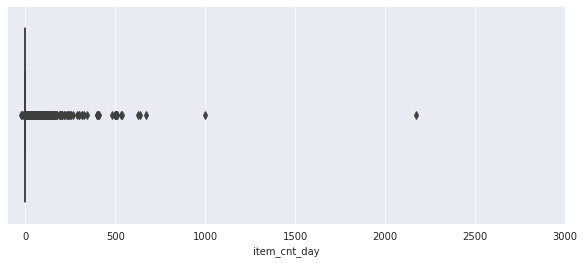

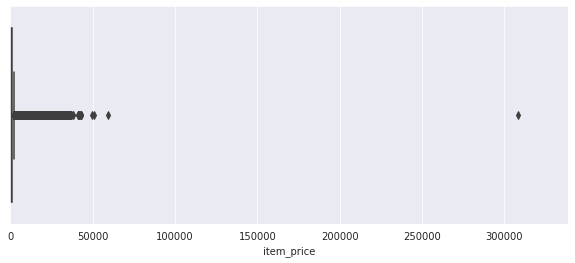

In [0]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [0]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [0]:
train[train['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


가격이 음수인 데이터를 같은 범위의 데이터의 중간값으로 변경

In [0]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

shop_id 변경

In [0]:
shops[shops['Name'].duplicated()]

,Name,shop_id,City,Type
11,Chkalov Str. 39 m2,11,Zhukovsky,Shop
37,Mega,37,Novosibirsk,TC
38,Mega,38,Omsk,TC
41,Mega,41,Rostov-on-Don,TC
54,Mega,54,Khimki,TC
58,Central,58,Yakutsk,SC


In [0]:
shops[shops['Name']=='Chkalov Str. 39 m2']

,Name,shop_id,City,Type
10,Chkalov Str. 39 m2,10,Zhukovsky,Shop
11,Chkalov Str. 39 m2,11,Zhukovsky,Shop


In [0]:
shops[shops['City']=='Novosibirsk']

,Name,shop_id,City,Type
36,Gallery Novosibirsk,36,Novosibirsk,TRC
37,Mega,37,Novosibirsk,TC


In [0]:
shops[shops['City']=='Omsk']

,Name,shop_id,City,Type
38,Mega,38,Omsk,TC


In [0]:
shops[shops['City']=='Rostov-on-Don']

,Name,shop_id,City,Type
39,Megacenter Horizon,39,Rostov-on-Don,TRC
40,Megacenter Horizon Island,40,Rostov-on-Don,TRC
41,Mega,41,Rostov-on-Don,TC


In [0]:
shops[shops['City']=='Khimki']

,Name,shop_id,City,Type
54,Mega,54,Khimki,TC


In [0]:
shops[shops['City']=='Yakutsk']

,Name,shop_id,City,Type
0,"Ordzhonikidze, 56 francs",0,Yakutsk,Shop
1,Central franc,1,Yakutsk,TC
57,"Ordzhonikidze, 56",57,Yakutsk,Shop
58,Central,58,Yakutsk,SC


In [0]:
# Ordzhonikidze, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Central
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Chkalov Str. 39 m2
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [0]:
items.head()

,item_name,item_id,item_category_id
0,!! IN THE POWER OF HAPPINESS (PLAST) D,0,40
1,! ABBYY FineReader 12 Professional Edition Ful...,1,76
2,*** IN THE GLORY OF THE GLORY (UNV) D,2,40
3,*** BLUE WAVE (Univ) D,3,40
4,*** BOX (GLASS) D,4,40


item을 type으로 나눠주고 라벨링

In [0]:
item_names = items.item_name.values
p = re.compile(r'\((.*?)\)', re.S)
features = []
for o in item_names:
    features.append(re.findall(p, o)[-2:])
features[:5]

[['PLAST'], [], ['UNV'], ['Univ'], ['GLASS']]

In [0]:
item_f1 = []
item_f2 = []

for o in features:
    if len(o) == 0:
        item_f1.append(np.nan)
        item_f2.append(np.nan)
    elif len(o) == 1:
        item_f1.append(o[0])
        item_f2.append(np.nan)
    else:
        item_f1.append(o[1])
        item_f2.append(o[0])

In [0]:
items['item_f1'] = pd.Series(item_f1)
items['item_f2'] = pd.Series(item_f2)
items['item_f1_code'] = LabelEncoder().fit_transform(items['item_f1'].fillna('xxx')).astype(np.int16)
items['item_f2_code'] = LabelEncoder().fit_transform(items['item_f2'].fillna('xxx')).astype(np.int16)
items.head()

,item_name,item_id,item_category_id,item_f1,item_f2,item_f1_code,item_f2_code
0,!! IN THE POWER OF HAPPINESS (PLAST) D,0,40,PLAST,NaN,737,255
1,! ABBYY FineReader 12 Professional Edition Ful...,1,76,NaN,NaN,1136,255
2,*** IN THE GLORY OF THE GLORY (UNV) D,2,40,UNV,NaN,881,255
3,*** BLUE WAVE (Univ) D,3,40,Univ,NaN,886,255
4,*** BOX (GLASS) D,4,40,GLASS,NaN,580,255


In [0]:
items.drop(['item_f1', 'item_f2'], 1, inplace=True)
items.drop(['item_name'], axis=1, inplace=True)
items.head()

,item_id,item_category_id,item_f1_code,item_f2_code
0,0,40,737,255
1,1,76,1136,255
2,2,40,881,255
3,3,40,886,255
4,4,40,580,255


shop을 도시와 shop_type별로 라벨링

In [0]:
shops.head()

,Name,shop_id,City,Type
0,"Ordzhonikidze, 56 francs",0,Yakutsk,Shop
1,Central franc,1,Yakutsk,TC
2,Mega,2,Adygea,TC
3,October-Kinomir,3,Balashikha,TRC
4,Volga Mall,4,Volzhsky,TC


In [0]:
shops['city_code'] = LabelEncoder().fit_transform(shops['City'])
shops['shop_type_code'] = LabelEncoder().fit_transform(shops['Type'])
shops = shops[['shop_id','city_code','shop_type_code']]
shops.head()

,shop_id,city_code,shop_type_code
0,0,26,3
1,1,26,4
2,2,0,4
3,3,1,5
4,4,23,4


카테고리별 라벨링

In [0]:
cats.head()

,item_category_name,item_category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4


In [0]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])

cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

cats.head()

,item_category_id,type_code,subtype_code
0,0,15,32
1,1,0,44
2,2,0,45
3,3,0,46
4,4,0,48


우리가 예측하려고 하는 (월, 상점, 상품) 형태의 matrix를 생성

In [0]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

월 단위의 판매량을 추가, robust하게 하기 위해 범위를 맞춰줌

In [0]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

test 데이터를 train과 같은 꼴로 만들어줌

In [0]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

matrix뒤에 붙여준다

In [0]:
matrix = pd.concat([matrix, test], ignore_index=True, keys=cols)
matrix.fillna(0, inplace=True) # 34 month

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


예측에 필요한 Feature들을 추가

In [0]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['shop_type_code'] = matrix['shop_type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

수개월 전의 판매량들을 가지고 예측

In [0]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [0]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

다양한 feature들 생성

In [0]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'item_category_id', 'item_f1_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_item_f1_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id', 'item_f1_code'], how='left')
matrix['date_cat_item_f1_avg_item_cnt'] = matrix['date_cat_item_f1_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_item_f1_avg_item_cnt')
matrix.drop(['date_cat_item_f1_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'item_category_id', 'item_f2_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_item_f2_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id', 'item_f2_code'], how='left')
matrix['date_cat_item_f2_avg_item_cnt'] = matrix['date_cat_item_f2_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_item_f2_avg_item_cnt')
matrix.drop(['date_cat_item_f2_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'shop_type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'item_id', 'shop_type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_shop_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_type_code'], how='left')
matrix['date_item_shop_type_avg_item_cnt'] = matrix['date_item_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_shop_type_avg_item_cnt')
matrix.drop(['date_item_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'subtype_code', 'item_f1_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_item_f1_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code', 'item_f1_code'], how='left')
matrix['date_subtype_item_f1_avg_item_cnt'] = matrix['date_subtype_item_f1_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_item_f1_avg_item_cnt')
matrix.drop(['date_subtype_item_f1_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'subtype_code', 'item_f2_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_item_f2_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code', 'item_f2_code'], how='left')
matrix['date_subtype_item_f2_avg_item_cnt'] = matrix['date_subtype_item_f2_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_item_f2_avg_item_cnt')
matrix.drop(['date_subtype_item_f2_avg_item_cnt'], axis=1, inplace=True)

현재 기준으로 지난 달 특정 feature의 값이 전체 평균보다 높은지 낮은지 구한다

1달전 값이 없을 경우 2달, 3달, 최대 6달전까지 확인

In [0]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

상점의 수입에 대한 트랜드를 Feature 로 만듦

In [0]:
train['revenue'] = train['item_price'] * train['item_cnt_day']

총 수입 트랜드도 만들어줌

In [0]:
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

그 외에 feature 추가

In [0]:
matrix['month'] = matrix['date_block_num'] % 12

In [0]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

상품이 해당 날짜 기준 몇달전에 팔렸는지 (상점, 상품별)

In [0]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num


상품별

In [0]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         

최초 판매 이후 몇개월이 지났는지

In [0]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

lag에 널값이 있으면 채워줌

In [0]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [0]:
matrix.columns

Index(['date_block_num', 'item_cnt_month', 'item_id', 'shop_id', 'city_code',
       'shop_type_code', 'item_category_id', 'item_f1_code', 'item_f2_code',
       'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_cat_item_f1_avg_item_cnt_lag_1',
       'date_cat_item_f2_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1_x',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',

In [0]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 49 columns):
date_block_num                             int8
item_cnt_month                             float16
item_id                                    int16
shop_id                                    int8
city_code                                  int8
shop_type_code                             int8
item_category_id                           int8
item_f1_code                               int16
item_f2_code                               int16
type_code                                  int8
subtype_code                               int8
item_cnt_month_lag_1                       float16
item_cnt_month_lag_2                       float16
item_cnt_month_lag_3                       float16
item_cnt_month_lag_6                       float16
item_cnt_month_lag_12                      float16
date_avg_item_cnt_lag_1                    float16
date_item_avg_item_cnt_lag_1               fl

In [0]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

In [0]:
data = pd.read_pickle('data.pkl')

In [0]:
data = data[data['date_block_num']>11]

In [0]:
data.head()

,date_block_num,item_cnt_month,item_id,shop_id,city_code,shop_type_code,item_category_id,item_f1_code,item_f2_code,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_cat_item_f1_avg_item_cnt_lag_1,date_cat_item_f2_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1_x,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1_y,date_item_city_avg_item_cnt_lag_1,date_item_shop_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,date_subtype_item_f1_avg_item_cnt_lag_1,date_subtype_item_f2_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4488710,12,0.0,27,2,0,4,19,1136,255,9,45,0.0,0.0,0.0,0.0,1.0,0.411377,0.086975,0.044434,0.130493,0.065247,0.155518,0.148071,0.100647,0.08905,0.096008,0.141235,1.082031,1.125000,1.052734,0.955566,0.808594,0.935059,0.148071,0.426514,0.0,0.074097,1.03418,1.075195,1.125977,1.050781,-0.282715,1.211914,0,31,1,1,12,12
4488711,12,0.0,30,2,0,4,40,1136,255,3,23,0.0,0.0,0.0,0.0,0.0,0.411377,1.021484,1.022461,0.521973,0.891113,0.000000,0.148071,0.100647,0.08905,0.096008,0.000000,0.291504,0.398682,0.290771,0.046234,0.051727,0.046234,0.148071,0.426514,0.0,0.962891,0.27002,0.291504,0.398682,0.290771,-0.483398,1.211914,0,31,1,1,11,11
4488712,12,0.0,31,2,0,4,37,390,255,3,9,0.0,0.0,0.0,0.0,0.0,0.411377,0.543457,0.600098,0.543457,0.304443,0.000000,0.148071,0.100647,0.08905,0.096008,0.000000,0.232788,0.227783,0.233276,0.059448,0.051727,0.064697,0.148071,0.426514,0.0,0.555664,0.27002,0.234009,0.227783,0.233887,-0.137451,1.211914,0,31,1,1,11,11
4488713,12,1.0,32,2,0,4,40,1136,255,3,23,0.0,0.0,0.0,0.0,0.0,0.411377,1.934570,1.799805,1.260742,1.891602,5.378906,0.148071,0.100647,0.08905,0.096008,0.141235,0.291504,0.398682,0.290771,0.046234,0.051727,0.046234,0.148071,0.426514,0.0,2.185547,0.27002,0.291504,0.398682,0.290771,-0.407227,1.211914,0,31,-1,1,12,12
4488714,12,1.0,33,2,0,4,37,390,255,3,9,1.0,2.0,0.0,0.0,1.0,0.411377,0.913086,0.333252,0.717285,1.000000,1.355469,0.148071,0.100647,0.08905,0.096008,0.141235,0.232788,0.227783,0.233276,0.059448,0.051727,0.064697,0.148071,0.426514,1.0,0.777832,0.27002,0.234009,0.227783,0.233887,-0.225464,1.211914,0,31,1,1,12,12


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 49 columns):
date_block_num                             int8
item_cnt_month                             float16
item_id                                    int16
shop_id                                    int8
city_code                                  int8
shop_type_code                             int8
item_category_id                           int8
item_f1_code                               int16
item_f2_code                               int16
type_code                                  int8
subtype_code                               int8
item_cnt_month_lag_1                       float16
item_cnt_month_lag_2                       float16
item_cnt_month_lag_3                       float16
item_cnt_month_lag_6                       float16
item_cnt_month_lag_12                      float16
date_avg_item_cnt_lag_1                    float16
date_item_avg_item_cnt_lag_1            

In [0]:
data = data[[
    'date_block_num',
    'item_cnt_month',
    'item_id',                     
    'shop_id',                        
    'city_code',                         
    'shop_type_code',             
    'item_category_id',                         
    'item_f1_code',         
    'item_f2_code',                  
    'type_code',                      
    'subtype_code',                            
    'item_cnt_month_lag_1',                   
    'item_cnt_month_lag_2',            
    'item_cnt_month_lag_3',                  
    'item_cnt_month_lag_6',                  
    'item_cnt_month_lag_12',                
    'date_avg_item_cnt_lag_1',               
    'date_item_avg_item_cnt_lag_1',         
    'date_item_avg_item_cnt_lag_2',         
    'date_item_avg_item_cnt_lag_3',         
    'date_item_avg_item_cnt_lag_6',         
    'date_item_avg_item_cnt_lag_12',       
    'date_shop_avg_item_cnt_lag_1',        
    'date_shop_avg_item_cnt_lag_2',        
    'date_shop_avg_item_cnt_lag_3',        
    'date_shop_avg_item_cnt_lag_6',        
    'date_shop_avg_item_cnt_lag_12',      
    'date_cat_avg_item_cnt_lag_1',          
    'date_cat_item_f1_avg_item_cnt_lag_1', 
    'date_cat_item_f2_avg_item_cnt_lag_1', 
    'date_shop_cat_avg_item_cnt_lag_1',    
    #'date_shop_type_avg_item_cnt_lag_1_x',        
    'date_shop_subtype_avg_item_cnt_lag_1',       
    'date_city_avg_item_cnt_lag_1',               
    #'date_shop_type_avg_item_cnt_lag_1_y',      
    'date_item_city_avg_item_cnt_lag_1',       
    'date_item_shop_type_avg_item_cnt_lag_1',    
    #'date_type_avg_item_cnt_lag_1',         
    #'date_subtype_avg_item_cnt_lag_1',     
    'date_subtype_item_f1_avg_item_cnt_lag_1',
    'date_subtype_item_f2_avg_item_cnt_lag_1',    
    'delta_price_lag',                      
    'delta_revenue_lag_1',                    
    'month',                                    
    'days',                                       
    'item_shop_last_sale',                     
    'item_last_sale',                            
    'item_shop_first_sale',                    
    'item_first_sale',
]]     

In [0]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [0]:
del data
gc.collect();

In [0]:
model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=300,
    colsample_bytree=_colsample,
    scale_pos_weight=1,
    sub_sample=0.8,
    eta=0.3,
    seed=42)

model.fit(
    X_train,
    Y_train,
    eval_metric="rmse",
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
    verbose=True,
    early_stopping_rounds=15)

In [0]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

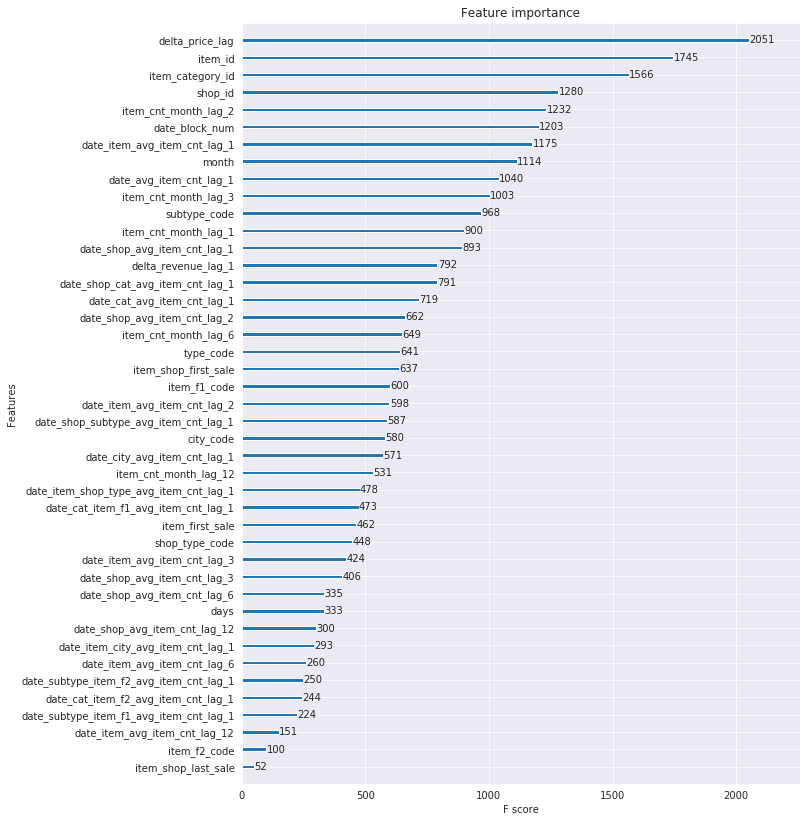

In [0]:
plot_features(model, (10,14))

In [0]:
depth_list = [5,6,7,8,9]
colsample_list = [0.7, 0.8, 0.9]

val_result_list = []
val_result_list.append(["max_depth", "colsample_bytree", "validation_rmse[0]", "validation_rmse[1]"])

for _max_depth in depth_list:
    for _colsample in colsample_list:
        print("[{0}/{1}] model fitting...".format(_max_depth, _colsample)) 
        
        model = XGBRegressor(
            max_depth=_max_depth,
            n_estimators=1000,
            min_child_weight=300,
            colsample_bytree=_colsample,
            scale_pos_weight=1,
            sub_sample=0.8,
            eta=0.3,
            seed=42)

        model.fit(
            X_train,
            Y_train,
            eval_metric="rmse",
            eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
            verbose=True,
            early_stopping_rounds=20)

        evals_result = model.evals_result()

        val_result_list.append(
            [_max_depth, _colsample, evals_result['validation_1']['rmse'][0], evals_result['validation_1']['rmse'][1]])

        print("[{0}/{1}] : val_rsme_0 = {2}, val_rsme_1 = {3}]".format(
            _max_depth, _colsample, evals_result['validation_1']['rmse'][0], evals_result['validation_1']['rmse'][1]))

pd.DataFrame(val_result_list).to_csv("validation_result.csv", sep=',', header=None, index=None, encoding='cp949')